In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np 
from tqdm import tqdm
import operator
import random 
from typing import Tuple

In [3]:
# deap-specific 
from deap import base, creator, tools, algorithms, gp
from deap import benchmarks 

## One-max problem 

Evolve until obtaining an individual with all 1s. 

In [6]:
n = 100 
pop_size = 200
max_gen = 100
cx_rate = 0.5
mut_rate = 0.2

In [7]:
# define types 
creator.create("FitnessMax", base.Fitness, weights = (1.0,))
creator.create("Individual", list, fitness = creator.FitnessMax)

/usr/local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [8]:
# initialisation 
toolbox = base.Toolbox() # toolbox container that contains all sort of functions to be used later
toolbox.register("attr", random.randint, 0, 1) # alias, function, argument 
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr, n) 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [10]:
# define & register operators
def eval(individual) -> Tuple:
    """
    fitness function 
    """
    return (np.sum(individual),)

def check_dup(ind, pop):
    import operator
    for p in pop:
        if operator.eq(ind, p):
            return True 
    return False 

toolbox.register("evaluate", eval)
# for (parent) selection, mutation, crossover
toolbox.register("mate", tools.cxTwoPoint) # toolx.cxOnePoint
toolbox.register("mutate", tools.mutFlipBit, indpb = 0.1)
toolbox.register("select", tools.selTournament, tournsize = 3) # k can be 2 or pop_size, # tools.selRoulette
toolbox.register("evaluate", eval)

In [11]:
# one-max ga algorithm 
def main(
    toolbox, 
    creator, 
    pop_size, 
    cx_rate, 
    mut_rate
) -> list:
    # init population 
    outs = []
    pop = toolbox.population(n = pop_size)
    # fitness computation 
    fitnesses = map(toolbox.evaluate, pop)
    for ind,fit in zip(pop, fitnesses):
        ind.fitness.values = fit 
    
    best = tools.HallOfFame(maxsize = 1)#, similar = ) 
    best.update(pop)
    
    # statistics -> average, max, min
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("mean", np.mean, axis = 0)
    stats.register("max", np.max, axis = 0)
    stats.register("min", np.min, axis = 0)
    stats_result = stats.compile(pop)
    # for logging
    logbook = tools.Logbook()
    logbook.record(
        gen = 0, 
        max = stats_result["max"],
        mean = stats_result["mean"], 
        min = stats_result["min"]
    )

    # loop 
    for idx in range(max_gen):
        next_pop = [] 
        # crossover & mutate  
        while len(next_pop) < pop_size: 
            p1, p2 = toolbox.select(pop, k = 2) 
            offsprings = algorithms.varAnd([p1, p2], toolbox, cx_rate, mut_rate) 
            for offspring in offsprings: 
                if len(next_pop) < pop_size and not check_dup(offspring, next_pop): 
                    next_pop.append(offspring) 
        # or 
        #next_pop = toolbox.select(pop, k = pop_size)
        #next_pop = list(map(toolbox.clone, next_pop)) # to ensure to work on the copy
        ## crossover
        #for child1, child2 in zip(next_pop[::2], next_pop[1::2]):
            #if random.random() < cx_rate:
                #toolbox.mate(child1, child2)
                #del child1.fitness.values 
                #del child2.fitness.values 
        ## mutate 
        #for child in next_pop:
            #if random.random() < mut_rate:
                #toolbox.mutate(child)
                #del child.fitness.values      

        # fitness evaluation 
        fitnesses = map(toolbox.evaluate, next_pop)
        for ind,fit in zip(next_pop, fitnesses):
            ind.fitness.values = fit 
        fitness_vs = [ind.fitness.values[0] for ind in next_pop]
        
        # next gen population selection 
        pop = tools.selBest(pop + next_pop, k = pop_size) 
        #pop[:] = next_pop # replacing
        
        best.update(pop) 
        #print (f"Gen {idx}, \n\tmin:{np.min(fitness_vs)}, max:{np.max(fitness_vs)}, avg:{np.round(np.mean(fitness_vs))}")
        			#Logging current status the pop
        stats_result = stats.compile(pop)
        max_v, min_v, mean_v = stats_result["max"], stats_result["min"], stats_result["mean"]
        logbook.record(gen = idx, max = max_v, mean = mean_v, min = min_v)
        print (logbook)
        
        print (f"\tGeneration {idx}: {max_v}(Max), {min_v}(AVG), {mean_v}(MIN)")
        #print ("\t\tbest individual: {} ({})".format(str(best[0]),best[0].fitness.values[0]))
        outs.append(fitness_vs)
        if np.max(fitness_vs) == len(pop[0]):
            return best, outs

founded, outs = main(
    toolbox, 
    creator, 
    pop_size, 
    cx_rate, 
    mut_rate
)

gen	max	mean  	min
0  	66 	50.045	40 
0  	66 	55.895	52 
	Generation 0: 66.0(Max), 52.0(AVG), 55.895(MIN)
gen	max	mean  	min
0  	66 	50.045	40 
0  	66 	55.895	52 
1  	68 	59.83 	57 
	Generation 1: 68.0(Max), 57.0(AVG), 59.83(MIN)
gen	max	mean  	min
0  	66 	50.045	40 
0  	66 	55.895	52 
1  	68 	59.83 	57 
2  	71 	63.195	60 
	Generation 2: 71.0(Max), 60.0(AVG), 63.195(MIN)
gen	max	mean  	min
0  	66 	50.045	40 
0  	66 	55.895	52 
1  	68 	59.83 	57 
2  	71 	63.195	60 
3  	73 	66.085	64 
	Generation 3: 73.0(Max), 64.0(AVG), 66.085(MIN)
gen	max	mean  	min
0  	66 	50.045	40 
0  	66 	55.895	52 
1  	68 	59.83 	57 
2  	71 	63.195	60 
3  	73 	66.085	64 
4  	78 	68.305	66 
	Generation 4: 78.0(Max), 66.0(AVG), 68.305(MIN)
gen	max	mean  	min
0  	66 	50.045	40 
0  	66 	55.895	52 
1  	68 	59.83 	57 
2  	71 	63.195	60 
3  	73 	66.085	64 
4  	78 	68.305	66 
5  	79 	70.69 	68 
	Generation 5: 79.0(Max), 68.0(AVG), 70.69(MIN)
gen	max	mean  	min
0  	66 	50.045	40 
0  	66 	55.895	52 
1  	68 	59.83 	57 
2  	7

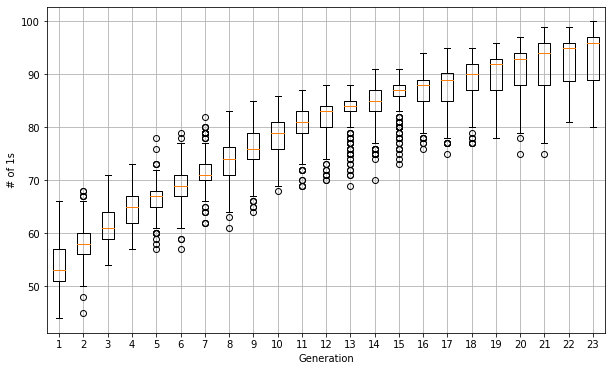

In [12]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.grid(which = 'major')
ax.boxplot(outs)
ax.set_xlabel("Generation")
ax.set_ylabel("# of 1s")
plt.show()

## Knapsack Problem

Given a set of items, each with a weight and a value, determine the number of each item to include in a collection 
so that the total weight is less than or equal to a given limit (i.e., mimimise) and the total value is as large as possible (i.e., maximise)

- Individual type: set 
- Initialisation: generate a random set
- Crossover: return intersection and difference of two candidates
- Mutation: pop or add an element to a set. If a set contains only one element, do nothing


In [107]:
IND_INIT_SIZE = 5
MAX_ITEM = 50
MAX_WEIGHT = 50 
N_ITEMS = 20

In [131]:
items = {}
np.random.seed(0)
for i in range(N_ITEMS):
    items[i] = (np.random.randint(1, 10), np.random.uniform(0, 100)) # weight, value

In [74]:
# define types
creator.create("Fitness", base.Fitness, weights = (-1.0, 1.0)) # minimise weight & maximise value
creator.create("Individual", set, fitness=creator.Fitness)

/usr/local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [157]:
# define operators & registert
toolbox = base.Toolbox()
#toolbox.register("attr_item", random.randrange, N_ITEMS)
#toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_item, IND_INIT_SIZE)
#toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [174]:
def cxSet(ind1, ind2):
    """
    return intersection and difference of the two 
    """
    temp = set(ind1)               
    ind1 &= ind2                   
    ind2 ^= temp                   
    return ind1, ind2

def mutSet(individual):
    """pop or add"""
    if np.random.random() < 0.5:
        if len(individual) > 1:
            individual.remove(random.choice(sorted(individual)))
    else:
        individual.add(random.randrange(N_ITEMS))
    return individual,

In [175]:
def evalKnapsack(individual):
    weight, value = 0.0, 0.0
    for item in individual:
        weight += items[item][0]
        value += items[item][1]

    if len(individual) > MAX_ITEM or weight > MAX_WEIGHT:
        return 10000, 0  # weight, value 
        
    return weight, value

In [176]:
# register
toolbox.register("evaluate", evalKnapsack)
toolbox.register("mate", cxSet)
toolbox.register("mutate", mutSet)
toolbox.register("select", tools.selNSGA2)

In [194]:
def main():
    NGEN = 50
    MU = 50
    LAMBDA = 100
    CXPB = 0.7
    MUTPB = 0.2

    pop = toolbox.population(n = MU)
    hof = tools.ParetoFront() # instead of 
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    pop = toolbox.population(n = MU)
    fitness_per_ind = toolbox.map(toolbox.evaluate, pop)
    for fit,ind in zip(fitness_per_ind, pop):
        ind.fitness.values = fit 
    
    stats_result = stats.compile(pop)
    logbook = tools.Logbook()
    logbook.record(
        gen = 0, 
        max = stats_result["max"],
        mean = stats_result["avg"], 
        min = stats_result["min"]
    )
    print (logbook)

    metric_lst = []
    pop = toolbox.select(pop, len(pop)) # will assign crowding distss
    # start 
    for idx in range(NGEN):
        offsprings = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)
        # evaluate & update fitness
        fitness_per_ind = toolbox.map(toolbox.evaluate, offsprings)
        for fit,ind in zip(fitness_per_ind, offsprings):
            ind.fitness.values = fit 

        # select the next generation population 
        np.random.seed(0)
        pop = toolbox.select(pop + offsprings, MU)
        hof.update(pop)
        hof.clear()
        
        stats_result = stats.compile(pop)
        max_v, min_v, mean_v = stats_result["max"], stats_result["min"], stats_result["avg"]
        logbook.record(gen = idx, max = max_v, mean = mean_v, min = min_v)
        print (logbook)

    hof.update(pop) 
    return pop, stats, hof

In [195]:
pop, stats, hof = main()

gen	max                        	mean                       	min                        
0  	[ 32.         400.89707022]	[ 22.4        283.20782274]	[ 10.         172.14757896]
gen	max                        	mean                       	min                        
0  	[ 32.         400.89707022]	[ 22.4        283.20782274]	[ 10.         172.14757896]
0  	[ 40.         573.81066312]	[ 19.         282.20295144]	[0. 0.]                    
gen	max                        	mean                       	min                        
0  	[ 32.         400.89707022]	[ 22.4        283.20782274]	[ 10.         172.14757896]
0  	[ 40.         573.81066312]	[ 19.         282.20295144]	[0. 0.]                    
1  	[ 49.         573.81066312]	[ 18.66       295.14182803]	[0. 0.]                    
gen	max                        	mean                       	min                        
0  	[ 32.         400.89707022]	[ 22.4        283.20782274]	[ 10.         172.14757896]
0  	[ 40.         573.81066312]	

In [196]:
hof